In [11]:
import easyocr
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [12]:
img = cv2.imread("temp.png")

In [13]:
reader = easyocr.Reader(['en'], gpu=True)
results = reader.readtext(img)

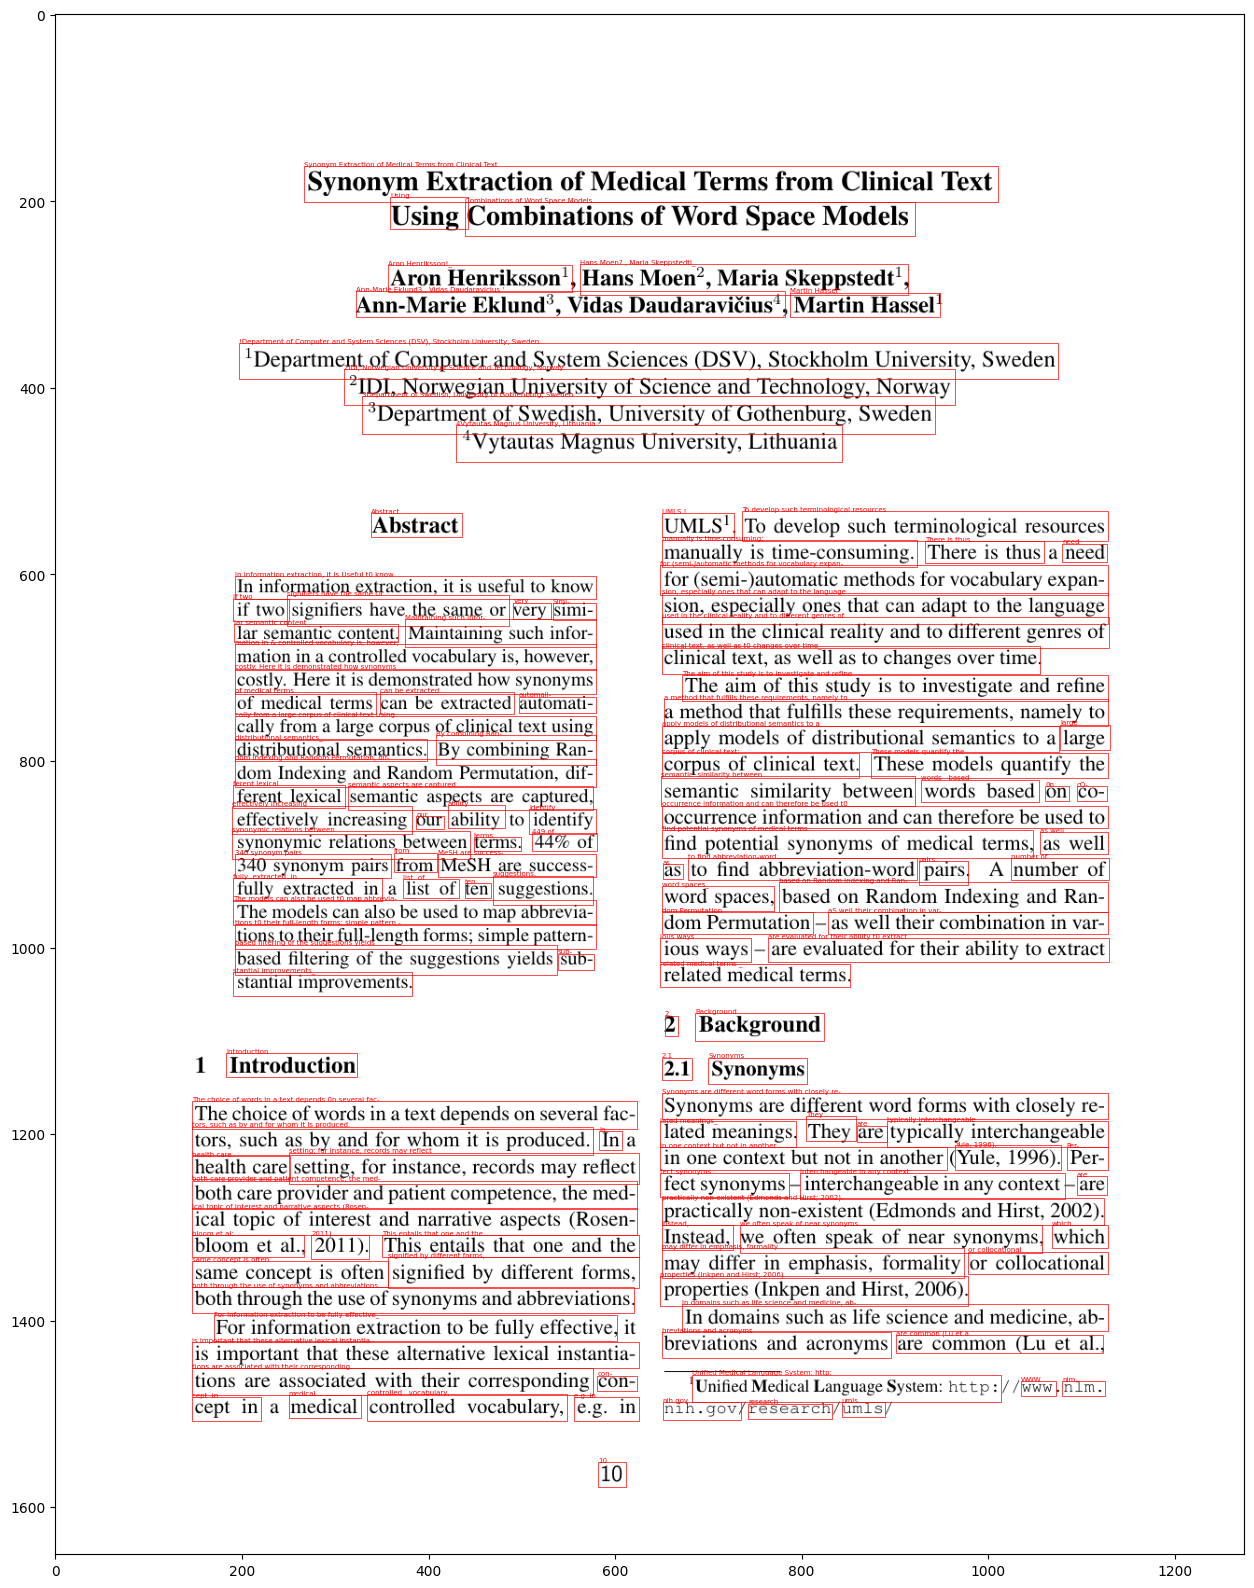

In [18]:
fig, ax = plt.subplots(figsize=(20, 20), dpi=100, frameon=True)
ax.imshow(img)

for result in results:
    bbox = result[0]
    text = result[1]
    patch = patches.Rectangle((bbox[0][0], bbox[0][1]), bbox[2][0]-bbox[-1][0], bbox[-1][1]-bbox[0][1], linewidth=0.5, edgecolor='r', facecolor='none')
    ax.add_patch(patch)
    ax.text(bbox[0][0], bbox[0][1], text, fontsize=5, color='r')
plt.show()